In [27]:
# This ipynb file is adapted from https://github.com/wagonhelm/TF_ObjectDetection_API/blob/master/ChessObjectDetection.ipynb

import skimage
import numpy as np
from skimage import io, transform
import os
import shutil
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import urllib.request
import urllib.error

%matplotlib inline

Before opening the Jupyter Notebook make sure you have cloned the `models` folder into the repository root directory and run the following from the root diretory to install the TensorFlow API

```bash
git clone https://github.com/tensorflow/models.git
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
cd ..
cd ..
```

Set Up Path Directories
--------------------------

In [28]:
root = os.getcwd()
imagePath = os.path.join(root, 'images')
labelsPath = os.path.join(root, 'labels')
linksPath = os.path.join(imagePath, 'imageLinks')
trainPath = os.path.join(imagePath, 'train')
testPath = os.path.join(imagePath, 'test')

In [29]:
root

'/Users/commstudies/project/Food_Detection'

In [30]:
import tensorflow as tf; print(tf.__version__)

1.11.0-dev20180913


Convert XML Labels to CSV
-----------------------------

In [17]:
# Modified From:
# https://github.comr/datitran/raccoon_dataset/blob/master/xml_to_csv.py

os.chdir(root)

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    
    for i in [trainPath, testPath]:
        image_path = i
        folder = os.path.basename(os.path.normpath(i))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('data/'+folder+'.csv', index=None)
        print('Successfully converted xml to csv.')
    
main()

Successfully converted xml to csv.
Successfully converted xml to csv.


Create TF Record
------------------------------------------------------

When training models with TensorFlow using [tfrecords](http://goo.gl/oEyYyR) files help optimize your data feed.  We can generate a tfrecord using code adapted from this [raccoon detector](https://github.com/datitran/raccoon_dataset/blob/master/generate_tfrecord.py).

In [5]:
%%bash 

python3 generate_tfrecord.py
mv test.record data
mv train.record data

Iterating test
Successfully created the test TFRecords
Iterating train
Successfully created the train TFRecords


In [6]:
%%bash

#wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
tar xvzf ssd_mobilenet_v1_coco_11_06_2017.tar.gz

x ssd_mobilenet_v1_coco_11_06_2017/
x ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.index
x ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.meta
x ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb
x ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.data-00000-of-00001
x ssd_mobilenet_v1_coco_11_06_2017/graph.pbtxt


Train Model
-------------


```bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
cd ..
cd ..

python3 models/research/object_detection/train.py --logtostderr --train_dir=data/ --pipeline_config_path=data/ssd_mobilenet_v1_pets.config --model_dir=data
```

Watch Training in TensorBoard
---------------------------------

We can use TensorBoard to monitor our total loss and other variables.  From the repository root directory run this command.

```bash
tensorboard --logdir='data'
```

Export Inference Graph
-------------------------

I highly recommend you expiriment with different checkpoints as your model trains.  We can get a list of all the ckpt files with the following.

In [20]:
%%bash 
cd trained_model
ls model*.index
cd ..

model.ckpt-2078.index
model.ckpt-2114.index
model.ckpt-2142.index
model.ckpt-2172.index
model.ckpt-2203.index


In [21]:
%%bash
pwd

/Users/commstudies/project/Livefit_Object_Detection


You can then added the cpkt number to our trained_checkpoint argument.

In [22]:
%%bash 
rm -rf data_object_detection_graph
python3 models/research/object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path data/ssd_mobilenet_v1_pets.config \
    --trained_checkpoint_prefix trained_model/model.ckpt-2203 \
    --output_directory data_object_detection_graph

Parsing Inputs...

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
param: Number of parameters (in the Variable).

Profile:
node

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
2018-12-09 16:47:43.763349: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:334] Starting optimization for grappler item: tf_graph
108 ops no flops stats due to incomplete shapes.
108 ops no flops stats due to incomplete shapes.


Test Model
-----------

In [23]:
# %%bash 
# python3 test.py

In [24]:
## same as test but with images

In [25]:
import skimage
import numpy as np
from skimage import io, transform
import os
import shutil
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import matplotlib; matplotlib.use('TkAgg')
from PIL import Image
import urllib.request
import urllib.error
import cv2
from utils.app_utils import FPS, WebcamVideoStream
from utils import label_map_util
from utils import visualization_utils as vis_util

/Users/commstudies/project/objectdetection/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/commstudies/project/objectdetection/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/commstudies/project/objectdetection/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

In [26]:
root = os.getcwd()
imagePath = os.path.join(root, 'images')
labelsPath = os.path.join(root, 'labels')
linksPath = os.path.join(imagePath, 'imageLinks')
trainPath = os.path.join(imagePath, 'train')
testPath = os.path.join(imagePath, 'test')

In [27]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'data_object_detection_graph/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/label_map.pbtxt'

NUM_CLASSES = 3

In [28]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [29]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [30]:
label_map

item {
  name: "apple"
  id: 1
}
item {
  name: "banana"
  id: 2
}
item {
  name: "orange"
  id: 3
}

In [31]:
categories

[{'id': 1, 'name': 'apple'},
 {'id': 2, 'name': 'banana'},
 {'id': 3, 'name': 'orange'}]

In [32]:
category_index

{1: {'id': 1, 'name': 'apple'},
 2: {'id': 2, 'name': 'banana'},
 3: {'id': 3, 'name': 'orange'}}

In [33]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [34]:
PATH_TO_TEST_IMAGES_DIR = 'images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 6) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [35]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

[{'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 1, 'name': 'apple'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 3, 'name': 'orange'}, {'id': 3, 'name': 'orange'}, {'id': 2, 'name': 'banana'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'bana

[{'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 3, 'name': 'orange'}, {'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 3, 'name': 'orange'}, {'id': 2, 'name': 'banana'}, {'id': 1, 'name': 'apple'}, {'id': 1, 'name': 'apple'}, {'id': 3, 'name': 'orange'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 3, 'name': 'orange'}, {'id': 3, 'name': 'orange'}, {'id': 3, 'name': 'orange'}, {'id': 1, 'name': 'apple'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 2, 'name': 'banana'}, {'id': 3, 'name': 'orange'}, {'id': 2, 'name': 'ba

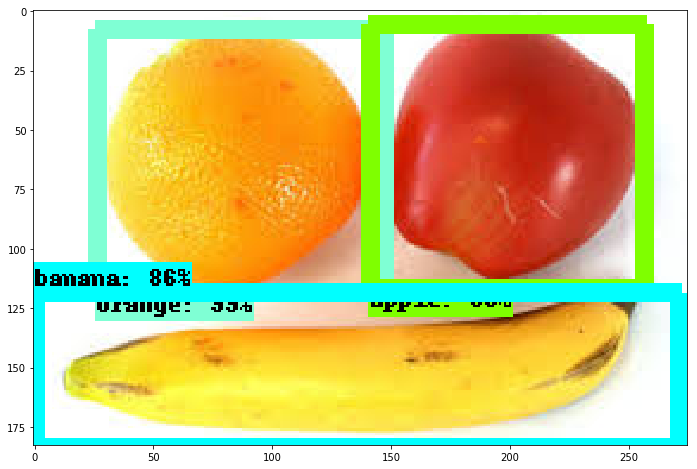

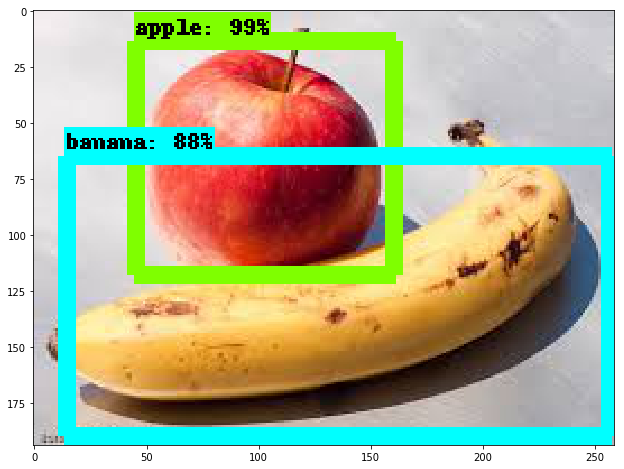

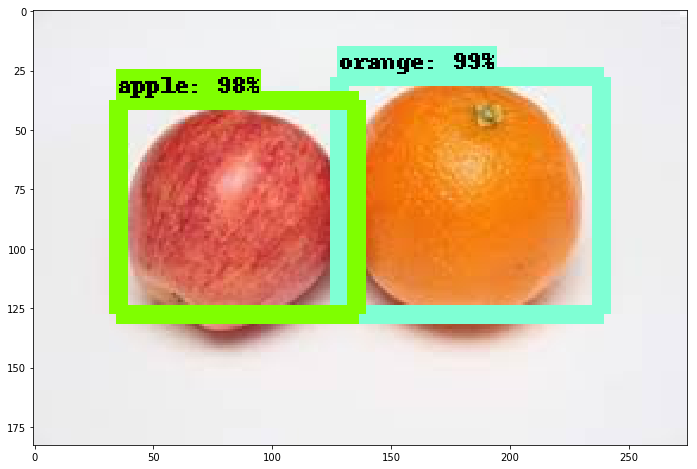

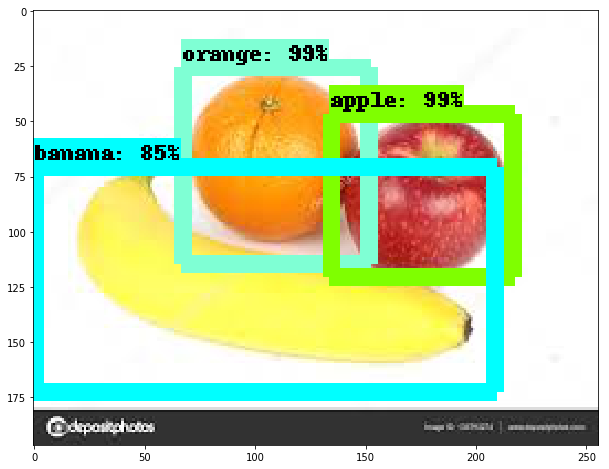

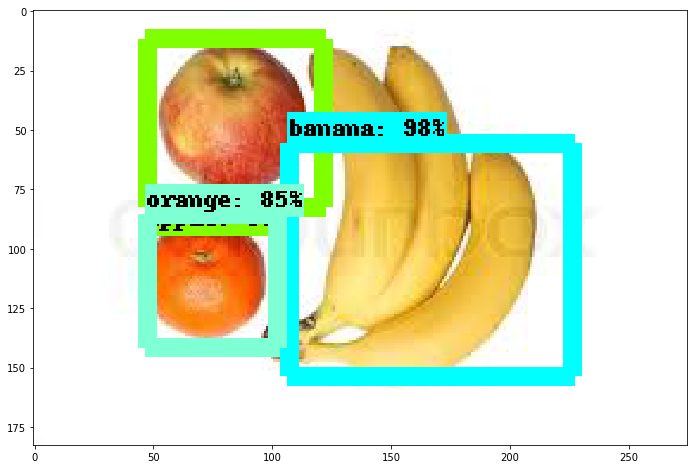

In [36]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  print([category_index.get(i) for i in output_dict['detection_classes']])
  print(output_dict['detection_scores'])
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [ ]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
    #src=0 --> /dev/video0. change src number according to your video node
    video_capture = WebcamVideoStream(src=0, 
                                      width=720,
                                      height=480).start()
    fps = FPS().start()
    while(True):
      frame =  video_capture.read()
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      image_np_expanded = np.expand_dims(frame_rgb, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})

      print('***************** Visualization ************')
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          frame_rgb,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=2)
      
      output_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
      cv2.imshow('Object Detection', output_rgb)
      fps.update()
      if cv2.waitKey(1) & 0xFF == ord('q'):
      	break